<a href="https://colab.research.google.com/github/DeeeTeeee/Sentiment-Classification-FineTunning/blob/main/Fine_tuning_Hugging_face_trainer_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just `3 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

In [ ]:
#Install the datasets library
!pip install datasets
!pip install sentencepiece
!pip install transformers datasets
!pip install transformers[torch]
!pip install accelerate
!pip install accelerate>=0.20.1
!pip install huggingface_hub
!pip3 install -q transformers datasets

In [101]:
# Import libraries
import os
import pandas as pd
import numpy as np
import plotly
import string
import re
import matplotlib.pyplot as plt
from google.colab import files
import nltk
from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.model_selection import train_test_split

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig, AdamW
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import mean_squared_error
from huggingface_hub import notebook_login



In [102]:
notebook_login()

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
# Load the dataset and display some values
df_train = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/zindi_challenge/data/Train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/zindi_challenge/data/Test.csv')
# A way to eliminate rows containing NaN values
df_train = df_train[~df_train.isna().any(axis=1)]
df_test = df_test[~df_test.isna().any(axis=1)]


In [105]:
# Set the max_colwidth option to a higher value
pd.set_option('display.max_colwidth', None)

Because this project is basiscally for finetunning, we are not concentrating on  the EDA part however for the sake of the dataset, we need to check and understand it...
so, we will use the `CRISP-DM framework`
# Cleaning and little EDA

In [106]:
df_train.sample(4)

,tweet_id,safe_text,label,agreement
5346,P0BIXOZR,AIDS N : Here's How The HPV Vaccine Can Help Cut The Risk Of Cancer In Gay Men: Many HIV-positive queer men already… <url>,1.0,1.0
7446,85HYN8YR,病院実習行くのにMMRと水疱瘡の抗体を調べたら$550の請求が来た。\r\n((((；ﾟДﾟ)))))))自分で保険会社に請求しろと言われた。取り敢えず自己負担だね。,0.0,1.0
1731,J8NCS086,"Dr. Art Caplan talks about ethical issue in global health: the moral challenge of ""good enough"" with respect to Cholera vaccinations.",1.0,1.0
8721,OQ1JEX8C,Does Breastfeeding Protect My Baby From Measles? <url> #US <url>,0.0,1.0


In [107]:
df_test.sample(4)

,tweet_id,safe_text
2678,II9IPK8S,People who are against vaccinating children are the people I hate the most in the world.
169,146W4L0B,"So scared of ebola, I'm going for a vaccine 😳"
2098,EK9K56OZ,"Yes we will...and thnks sug""<user> <user> happy bday u are truly talented we gon make a mill one day!!!! #MMR"""
3296,MQP0H9DO,Better get your kids vaccinated so they don't catch these hands


# Data cleaning

Here I:\
Remove unnecessary columns\
Clean the 'safe_text' column\
Remove emojis and other special characters\
Remove punctuation


In [108]:
# Remove unnecessary columns
df_train = df_train.drop(['tweet_id'], axis=1)
df_test = df_test.drop(['tweet_id'], axis=1)

In [109]:
# Clean the 'safe_text' column (example: remove URLs and special characters)
df_train['safe_text'] = df_train['safe_text'].str.replace(r'<url>', '')  # Remove <url> tag
df_test['safe_text'] = df_test['safe_text'].str.replace(r'<url>', '')  # Remove <url> tag

# Remove emojis and other special characters
emojis = re.compile(r'[^\w\s@#$%^*()<>/|}{~:]')
df_train["safe_text"] = df_train["safe_text"].str.replace(emojis, '')
df_test["safe_text"] = df_test["safe_text"].str.replace(emojis, '')

# # Remove punctuation
punctuation = string.punctuation
df_train["safe_text"] = df_train["safe_text"].str.translate(str.maketrans('', '', punctuation))
df_test["safe_text"] = df_test["safe_text"].str.translate(str.maketrans('', '', punctuation))

In [110]:
df_train.sample(4)

,safe_text,label,agreement
1668,Measles were eradicated in the USA in 2000 Thanks to AntiVaccine advocates it is back Took these idiots 14 years Thanks Jenny McCarthy,1.0,1.000000
2682,Measles cases continue to spread in California,0.0,0.666667
4017,Come Feel The Love user mmr urkel carl eddie stefanurkel 90s tgif familymatters mypet,0.0,1.000000
8898,WakeUpAmerica Forced vaccinations are the way to go The children will be carriers after they recover so parents must take responsibility,1.0,1.000000


In [111]:
df_test.head(4)

,safe_text
0,user user amp 4 a vaccine given 2 healthy peeps FDA think just not worth the AE risk unfortunately
1,Students starting school without whooping cough vaccinations scpick
2,Im kinda over every ep of user being ripped from the headlines Measles Lets get back to crime SVU
3,How many innocent children die for lack of vaccination each year Around 15 million Too bad all their parents couldnt be here SB277


Let's for the Fine Tunning to be smoother, let us make the case of the text uniform. I will make it `lowercase`

In [112]:
# Turn the safe_text column into lowercase
df_train["safe_text"] = df_train["safe_text"].str.lower()
df_test["safe_text"] = df_test["safe_text"].str.lower()

### EDA

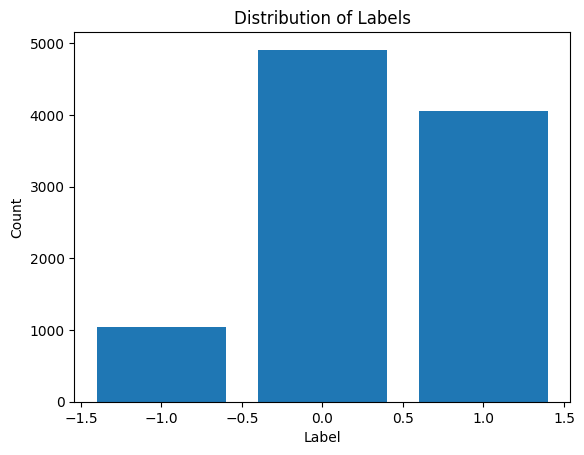

In [113]:
# Plot the distribution of labels
label_counts = df_train['label'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

In [114]:
df_train['label'].unique()

array([ 0.,  1., -1.])

Distribution of Label Agreement:

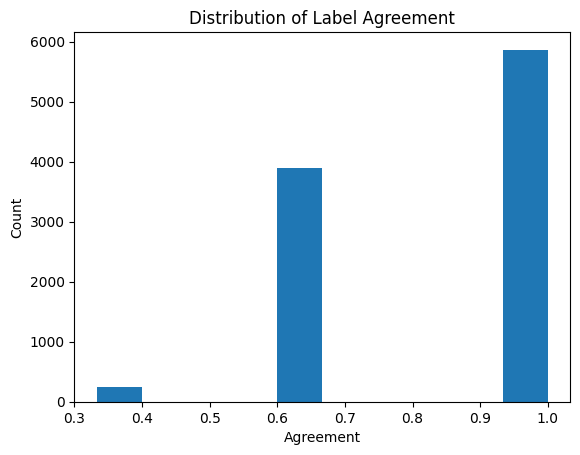

In [115]:
# Plot the distribution of 'agreement'
plt.hist(df_train['agreement'])
plt.xlabel('Agreement')
plt.ylabel('Count')
plt.title('Distribution of Label Agreement')
plt.show()

In [116]:
from collections import Counter

# Concatenate all the 'safe_text' into a single string
text = ' '.join(df_train['safe_text'])

# Split the text into words
words = text.split()

# Count the frequency of each word
word_counts = Counter(words)

# Display the most common words
print(word_counts.most_common(10))


[('user', 5494), ('the', 4118), ('to', 3636), ('measles', 3512), ('a', 2453), ('of', 2354), ('in', 2174), ('and', 1993), ('i', 1705), ('is', 1615)]


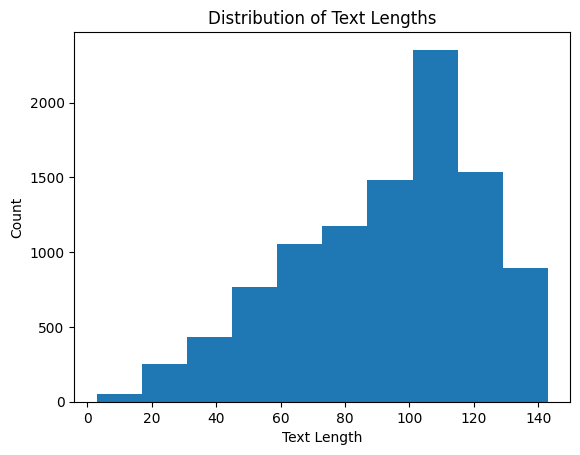

In [117]:
# Calculate the length of each text in 'safe_text'
text_lengths = df_train['safe_text'].apply(len)

# Plot the distribution of text lengths
plt.hist(text_lengths)
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.title('Distribution of Text Lengths')
plt.show()

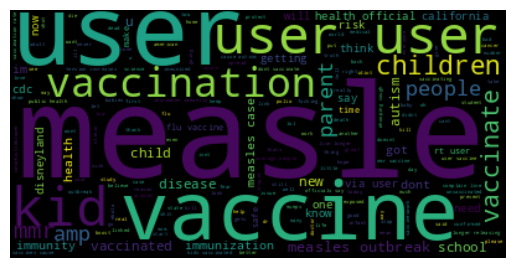

In [118]:
from wordcloud import WordCloud

# Generate the word cloud
wordcloud = WordCloud().generate(text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [119]:
# Calculate the correlation between 'label' and 'agreement'
correlation = df_train['label'].corr(df_train['agreement'])

# Print the correlation value
print(f"Correlation: {correlation}")


Correlation: 0.13815479087588003


In [120]:
df_train.head(5)

,safe_text,label,agreement
0,me amp the big homie meanboy3000 meanboy mb mbs mmr stegmanlife stegman st,0.0,1.0
1,im 100 thinking of devoting my career to proving autism isnt caused by vaccines due to the idiotic posts ive seen about world autism day,1.0,1.0
2,whatcausesautism vaccines do not vaccinate your child,-1.0,1.0
3,i mean if they immunize my kid with something that wont secretly kill him years down the line then im all for it but i dont trust that,-1.0,1.0
4,thanks to user catch me performing at la nuit nyc 1134 1st ave show starts at 6 jennifair mmr,0.0,1.0


In [121]:
df_test.head(5)

,safe_text
0,user user amp 4 a vaccine given 2 healthy peeps fda think just not worth the ae risk unfortunately
1,students starting school without whooping cough vaccinations scpick
2,im kinda over every ep of user being ripped from the headlines measles lets get back to crime svu
3,how many innocent children die for lack of vaccination each year around 15 million too bad all their parents couldnt be here sb277
4,cdc eyeing bird flu vaccine for humans though risk is low federal officials said wednesday theyre taking steps


## Removing Stop Words

In [122]:
# Download the stop words (only required for the first time)
nltk.download('stopwords')

# Remove stop words
stop_words = set(stopwords.words('english'))
df_train['safe_text'] = df_train['safe_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
''.join(stop_words)

"don'tarencouldn'twonthemjustthosebelowforwhatandsothanhowhadn'thavenwhoredidn'tmostormoreyou'vebecausearen'tmaitselfwasshouldduringshan'totherdonaintheirswhileonsamethehadnammyselfbeinginhersdoingdonlyshould'veit'sfromunderyoutomybehimooursnothaveifthatyoursbothwhomtheseandoesnneednthat'llhasn'tweren'tshannowoutsomeaboutagainhisoffwherewasnherselfourselvesfurtherdidnyyourselvesveryveagainstwon'tyourareallhefewnorwhenwhybeforehasnhereowndoestwasn'thavingupisnshebyoncewemightnthroughwerenovermightn'tbeennollhimselfneedn'twithmustn'tanyyou'llshe'sshouldn'ttooabovedownherintosuchyou'ditshouldnwouldn'tafterwerethemselvesmeididatyou'reisuntilbetweenmitseachdoesn'tbutmustnwhichdoatheirhashadthisthencanwillourtheresisn'twouldnyourselftheyhaven'tofcouldnas"

In [124]:
#Sample after removing stopwords
df_train.head(4)

,safe_text,label,agreement
0,amp big homie meanboy3000 meanboy mb mbs mmr stegmanlife stegman st,0.0,1.0
1,im 100 thinking devoting career proving autism isnt caused vaccines due idiotic posts ive seen world autism day,1.0,1.0
2,whatcausesautism vaccines vaccinate child,-1.0,1.0
3,mean immunize kid something wont secretly kill years line im dont trust,-1.0,1.0


#### Save the DataFrames to CSV files:

In [125]:
# Save df_train
df_train.to_csv('df_train.csv', index=False)

# Save df_test
df_test.to_csv('df_test.csv', index=False)

Download the CSV files to your local machine:

I manually split the training set to have a training subset ( a dataset the model will learn on), and an evaluation subset ( a dataset the model with use to compute metric scores to help use to avoid some training problems like [the overfitting](https://www.ibm.com/cloud/learn/overfitting) one ).

There are multiple ways to do split the dataset. You'll see two commented line showing you another one.

## Import the Cleaned data:

In [129]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [130]:
# Load the dataset and display some values
df = pd.read_csv('/content/df_train.csv')

# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

In [131]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [132]:
# Display the first few rows of the training data
train.head(5)

,safe_text,label,agreement
9303,mickeys measles gone international,0.0,1.000000
3907,s1256 new extends exemption charitable immunity certain civil actions persons age,0.0,1.000000
795,user ignorance vaccines isnt dangerous innocent child others around shame,1.0,0.666667
5791,pakistan partly suspends polio vaccination program terrorists kill health workers,0.0,1.000000
3431,news ive gone like 1000 mmr,0.0,1.000000


In [133]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7999 entries, 9303 to 1387
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   safe_text  7999 non-null   object 
 1   label      7999 non-null   float64
 2   agreement  7999 non-null   float64
dtypes: float64(2), object(1)
memory usage: 250.0+ KB


In [134]:
# Display the first few rows of the evaluation data
eval.head()

,safe_text,label,agreement
6569,childrens museum houston offer free vaccinations,1.0,1.000000
1754,user properly immunized prior performance kid puts legit show say,1.0,1.000000
3325,user thx posting vaccinations imperative dear puppy know died parvo terrible death humans wise,1.0,1.000000
1485,baby exactly everyone needs vaccinate via user,1.0,0.666667
4175,meeting tonight 830pm room 322 student center kent ksu kentstate immunizations childrenfirst,1.0,1.000000


In [135]:
eval.label.unique()

array([ 1., -1.,  0.])

In [136]:
# Print the shapes of the new dataframes
print(f"Shape of the train dataframe: {train.shape}")
print(f"Shape of the eval dataframe: {eval.shape}")

Shape of the train dataframe: (7999, 3)
Shape of the eval dataframe: (2000, 3)


In [137]:
# # Save splitted subsets
# train.to_csv("../data/train_subset.csv", index=False)
# eval.to_csv("../data/eval_subset.csv", index=False)
import os
import pandas as pd

# Create the data directory if it doesn't exist
if not os.path.exists("../data"):
    os.makedirs("../data")

# Save splitted subsets
train.to_csv("../data/train_subset.csv", index=False)
eval.to_csv("../data/eval_subset.csv", index=False)


In [138]:
# Load the dataset from CSV files
dataset = load_dataset('csv',
                        data_files={'train': '../data/train_subset.csv',
                        'eval': '../data/eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-3af1f0f1b5a125ee/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [139]:

#!pip install transformers

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# "cardiffnlp/twitter-xlm-roberta-base-sentiment"
# "roberta-base"
# "xlnet-base-cased"
# "bert-base-uncased"

# Import the tokenizer from transformers library
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment')

In [140]:
# Function to transform labels
def transform_labels(label):
    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

# Function to tokenize data
def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [141]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [144]:
from transformers import TrainingArguments
import transformers

# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
# Training Arguments
training_args = TrainingArguments(
    output_dir="mytest_trainer_robert",
    num_train_epochs=10,
    load_best_model_at_end=True,
    #output_dir="SentimentAnalysisDee1",
    push_to_hub=True,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=100,
    per_device_train_batch_size=16,
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [145]:
from transformers import AutoModelForSequenceClassification

# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment", num_labels=3)

In [146]:
# Train and Evaluation Datasets
train_dataset = dataset['train'].shuffle(seed=25) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=25)

## other way to split the train set ... in the range you must use:
# # int(num_rows*.8 ) for [0 - 80%] and  int(num_rows*.8 ),num_rows for the 20% ([80 - 100%])
# train_dataset = dataset['train'].shuffle(seed=10).select(range(40000))
# eval_dataset = dataset['train'].shuffle(seed=10).select(range(40000, 41000))

In [147]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"rmse": mean_squared_error(labels, predictions, squared=False)}

In [ ]:
# Model Training Setup
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)


In [149]:
# Launch the learning process: training
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rmse
1,0.736500,0.699212,0.754321
2,0.607900,0.653198,0.684105
3,0.479800,0.703411,0.682276
4,0.345100,0.775705,0.692459
5,0.256000,1.095936,0.726636
6,0.181800,1.221279,0.677495
7,0.140700,1.486252,0.676387
8,0.093800,1.721256,0.703207
9,0.062300,1.823682,0.691737
10,0.048400,1.861722,0.692820


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


TrainOutput(global_step=5000, training_loss=0.29522066650390627, metrics={'train_runtime': 2161.5429, 'train_samples_per_second': 37.006, 'train_steps_per_second': 2.313, 'total_flos': 1173817304306010.0, 'train_loss': 0.29522066650390627, 'epoch': 10.0})

Don't worry the above issue, it is a `KeyboardInterrupt` that means I stopped the training to avoid taking a long time to finish.

In [ ]:
trainer.push_to_hub()

In [152]:
# Launch the final evaluation
trainer.evaluate()

{'eval_loss': 0.6531983613967896,
 'eval_rmse': 0.6841052550594828,
 'eval_runtime': 4.4193,
 'eval_samples_per_second': 452.557,
 'eval_steps_per_second': 56.57,
 'epoch': 10.0}

Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

Do not hesitaite to read more and to ask questions, the Learning is a lifelong activity.

In [153]:
#!pip show transformers
#!pip install transformers==2.4.0

In [ ]:
model = transformers.AutoModel.from_pretrained("mytest_trainer_robert")